<a href="https://colab.research.google.com/github/Teacher-Heiko/fastbook/blob/master/MaxPool_Dropout_BatchNorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np



In [2]:
# # Download and prepare the dataset
# transform = transforms.Compose([
#     transforms.ToTensor(),
# ])

# dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [3]:
from fastai.vision.all import *

path = untar_data(URLs.MNIST)

In [4]:
Path.BASE_PATH = path

def get_dls(bs=512):
    return DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
        get_items=get_image_files,
        splitter=GrandparentSplitter('training','testing'),
        get_y=parent_label,
        batch_tfms=Normalize()
    ).dataloaders(path, bs=bs)

dls = get_dls()

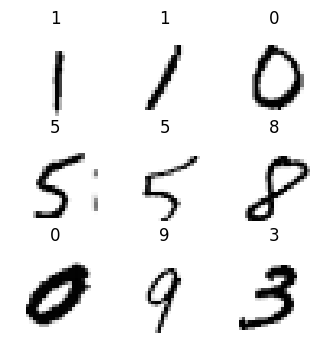

In [5]:
dls.show_batch(max_n=9, figsize=(4,4))

In [6]:
def simple_cnn():
   return nn.Sequential(
      nn.Conv2d(1, 4, kernel_size=(3,3), stride=1, padding=1), # Output Size: [4, 28, 28] (4 channels, 28x28 pixels)
      nn.ReLU(),

      nn.Conv2d(4, 8, kernel_size=(3,3), stride=1, padding=1), # [8, 28, 28] (8 channels, 28x28 pixels)
      nn.ReLU(),

      nn.Flatten(),
      nn.Linear(8*28*28, 64),
      nn.Linear(64, 10)
   )

In [7]:
simple_cnn()

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=6272, out_features=64, bias=True)
  (6): Linear(in_features=64, out_features=10, bias=True)
)

In [8]:
def fit(epochs=1):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    print(learn.summary())
    learn.fit(epochs, 0.6)
    return learn

In [9]:
#  learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    # metrics=accuracy, cbs=ActivationStats(with_hist=True))

In [10]:
# learn.lr_find()

In [11]:
# learn = fit()

<figure>
<!-- <img src="./images/2-convmodel-2.png" width="250" alt="Diagram of a convolutional model."> -->
<img src="https://storage.googleapis.com/kaggle-media/learn/images/Vko6nCK.png" width="250" alt="Diagram of a convolutional model.">
</figure>

In [12]:
def simple_cnn_max():
   return nn.Sequential(
      nn.Conv2d(1, 32, kernel_size=(3,3), stride=1, padding=1), # Output Size: [32, 28, 28]
      nn.ReLU(),
      nn.MaxPool2d(2),                                         # Output Size: [32, 14, 14]

      nn.Conv2d(32, 64, kernel_size=(3,3), stride=1, padding=1), # [64, 14, 14]
      nn.ReLU(),
      nn.MaxPool2d(2),                                          # [64, 7, 7]

      nn.Conv2d(64, 128, kernel_size=(3,3), stride=1, padding=1), # [128, 7, 7]
      nn.ReLU(),
      nn.Conv2d(128, 512, kernel_size=(3,3), stride=1, padding=1), # [512, 7, 7]
      nn.ReLU(),
      nn.Conv2d(512, 1024, kernel_size=(3,3), stride=1, padding=1), # [1024, 7, 7]
      nn.ReLU(),
      nn.MaxPool2d(2),                                          # [1024, 3, 3]


      nn.Flatten(),
      nn.Linear(1024 * 3 * 3, 512),   # Input size should match the number of flattened features
      nn.Dropout(0.2),
      nn.Linear(512, 64),
      nn.Linear(64, 10)

   )

simple_cnn_max()

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=9216, out_features=512, bias=True)
  (15): Dropout(p=0.2, inplace=False)
  (16): Linear(in_features=512, out_features=64, bias=True)
  (17): Linear(in_features=64, out_features=10, bias=True)
)

In [13]:
# def fit_max(epochs=1, lr=0.06):
#     learner = Learner(dls, simple_cnn_max(), loss_func=F.cross_entropy,
#                     metrics=accuracy, cbs=ActivationStats(with_hist=True))
#     learner.fit_one_cycle(epochs, lr)
#     return learner

In [14]:
# learn_max = fit_max()

In [15]:
# learn_max.activation_stats.plot_layer_stats(-1)

In [16]:
def simple_cnn_batchnorm():
    return nn.Sequential(
        nn.Conv2d(1, 8, kernel_size=(3, 3), stride=2, padding=1),  # Output Size: [8, 14, 14]
        nn.ReLU(),
        nn.BatchNorm2d(8),
        # nn.Dropout(0.2),

        nn.Conv2d(8, 64, kernel_size=(3, 3), stride=2, padding=1),  # Output Size: [64, 7, 7]
        nn.ReLU(),
        nn.BatchNorm2d(64),
        # nn.Dropout(0.3),

        nn.Conv2d(64, 128, kernel_size=(3, 3), stride=2, padding=1),  # Output Size: [128, 5, 5]
        nn.ReLU(),
        nn.BatchNorm2d(128),
        # nn.Dropout(0.4),

        nn.Conv2d(128, 256, kernel_size=(3, 3), stride=2, padding=1),  # Output Size: [256, 2, 2]
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.Dropout(0.4),

        nn.Conv2d(256, 512, kernel_size=(3, 3), stride=2, padding=1),  # Output Size: [512, 1, 1]
        nn.ReLU(),
        nn.BatchNorm2d(512),
        nn.Dropout(0.5),

        nn.Flatten(),

        nn.Linear(512 * 1 * 1, 256),  # Input size should match the number of flattened features
        nn.Dropout(0.5),

        nn.Linear(256, 64),
        # nn.Dropout(0.5),

        nn.Linear(64, 10)
    )

# simple_cnn_batchnorm()

In [17]:
# def fit_batchnorm(epochs=1, lr=0.06):
#     learner = Learner(dls, simple_cnn_batchnorm(), loss_func=F.cross_entropy,
#                     metrics=accuracy, cbs=ActivationStats(with_hist=True))
#     print(learner.summary())
#     learner.fit_one_cycle(epochs, lr)
#     return learner

In [18]:
learner = Learner(dls, simple_cnn_batchnorm(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))

In [19]:
learner.summary()


/usr/local/lib/python3.10/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


Sequential (Input shape: 512 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     512 x 8 x 14 x 14   
Conv2d                                    80         True      
ReLU                                                           
BatchNorm2d                               16         True      
____________________________________________________________________________
                     512 x 64 x 7 x 7    
Conv2d                                    4672       True      
ReLU                                                           
BatchNorm2d                               128        True      
____________________________________________________________________________
                     512 x 128 x 4 x 4   
Conv2d                                    73856      True      
ReLU                                                           
BatchNorm2d                               256        True      
____________________________________

In [20]:
learner.model

Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Conv2d(8, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): ReLU()
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): ReLU()
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (10): ReLU()
  (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): Dropout(p=0.4, inplace=False)
  (13): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (14): ReLU()
  (15): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (16): Dropout(p=0.5, inplace=False)
  (17): Flatten(start_dim=1, end_

In [21]:
learner.model.cuda()

Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Conv2d(8, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): ReLU()
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): ReLU()
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (10): ReLU()
  (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): Dropout(p=0.4, inplace=False)
  (13): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (14): ReLU()
  (15): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (16): Dropout(p=0.5, inplace=False)
  (17): Flatten(start_dim=1, end_

In [22]:
learner.fit_one_cycle(n_epoch=55)

epoch,train_loss,valid_loss,accuracy,time
0,0.797439,0.230889,0.928600,00:22
1,0.196370,0.068406,0.978900,00:23
2,0.095700,0.057745,0.982200,00:23
3,0.069332,0.055504,0.984000,00:22
4,0.053351,0.042699,0.986800,00:23
5,0.038800,0.045829,0.985900,00:24
6,0.030332,0.045208,0.987800,00:24
7,0.022806,0.046240,0.986500,00:25
8,0.017662,0.043999,0.989200,00:25
9,0.012742,0.043365,0.989200,00:25


In [23]:
# learn_batchnorm = fit_batchnorm()

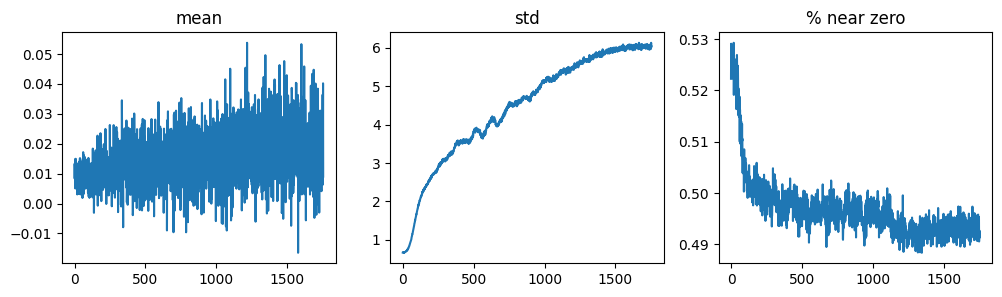

In [24]:
learner.activation_stats.plot_layer_stats(-2)